# A self-contained tutorial on Lagrangian Neural Networks (LNNs)
magnussross and Parth Sharma(this notebook), Miles Cranmer (derivation), Stephan Hoyer and Sam greydanus(derivation, code). Ported to deepchem by Parth Sharma (PsVenom)

$\quad$

![LNNs](https://raw.githubusercontent.com/greydanus/greydanus.github.io/master/files/lnn.png)

$\quad$

## Summary

This notebook explores Lagrangian Neural Networks (LNNs), which harness the expressive power of neural networks to learn arbitrary Lagrangians from data. In contrast to [Hamiltonian Neural Networks](https://greydanus.github.io/2019/05/15/hamiltonian-nns/), these models do not require canonical coordinates and perform well in situations where generalized momentum is difficult to compute (eg the [double pendulum](https://diego.assencio.com/?index=e5ac36fcb129ce95a61f8e8ce0572dbf)). This is particularly appealing for use with a learned latent representation, though this application is a work in progress. Unlike [previous work on learning Lagrangians](https://arxiv.org/pdf/1907.04490.pdf), LNNs can learn arbitrary Lagrangians.

|	| Neural Networks  | [Neural ODEs](https://arxiv.org/abs/1806.07366) | [HNNs](https://arxiv.org/abs/1906.01563)  | [DeLaN (ICLR'19)](https://arxiv.org/abs/1907.04490) | LNNs (this work) |
| ------------- |:------------:| :------------:| :------------:| :------------:| :------------:|
| Can model dynamical systems | ✔ | ✔ | ✔ | ✔ | ✔ |
| Learns differential equations | | ✔ | ✔ | ✔ | ✔ |
| Learns exact conservation laws | | | ✔ | ✔ | ✔ |
| Learns from arbitrary coords. |✔ | ✔|| ✔ | ✔ |
| Learns arbitrary Lagrangians | | |  | | ✔ |

## Lagrangians
Following David Morin's [excellent introduction to Lagrangians](http://www.people.fas.harvard.edu/~djmorin/chap6.pdf), we define the Lagrangian as a scalar function $L\equiv T-V$ with $T$ and $V$ as kinetic and potential energies, respectively. It turns out that we can obtain the equations of motion of an arbitrary physical system using the relationship
$$
\frac{d}{dt} \frac{\partial L}{\partial \dot q_j} = \frac{\partial L}{\partial q_j}
$$
We call this the _Euler-Lagrange (E-L) equation_ and we obtain it by requiring that the the quantity
$$S \equiv \int_{t_1}^{t_2} L(q, \dot q, t) dt$$
have a stationary value. In other words, we require that $S$ be at a local minimum, maximum, or saddle point. We call $S$ the "action" of the system, so the E-L relationship is a mathematical tool for describing its "path of stationary action". One way to think of $S$ is as the cost function that Nature minimizes in order to give us the dynamics of the natural world.

## **Step 1: Basic imports**
We will implement this project in Pytorch

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from functools import partial
from torch.autograd.functional import jacobian, hessian

from torchdiffeq import odeint as tor_odeint
from torchdiffeq import odeint_adjoint as tor_odeintadj
torch.version.__version__

'2.3.0'

### Make sure we're using a GPU

In [2]:
torch.cuda.is_available()

True

## **Step 2: Model the Spring Pendulum**


Lagrangian for spring pendulum, in 2D, with $r$ spring length, $\theta$ angle from vertical: 

$\mathcal{L} = T - V = \frac{1}{2}\dot{r}^2 + \frac{1}{2} r^2\dot{\theta}^2 - gr(1-\cos(\theta)) - k(r -r_0)^2$

By applying Euler Lagrange equataions get:

$\ddot r = r\dot{\theta}^2 + g(1-\cos(\theta)) - 2k(r-r_0)$

and 

$\ddot \theta = -\frac{1}{r}(g\sin(\theta) + 2\dot{r}\dot{\theta})$

can use these and `odeint` to solve analytically.



In [3]:
def lagrangian(x, g=10, k=10):
    q, qt = torch.split(x, 2)
    T = 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
    V = g*q[0]*(1-torch.cos(q[1])) + k*(q[0] - 1)**2
    return T - V 

def E(x, g=10, k=10): 
    try:
        q, qt = torch.split(x, 2)
        cos = torch.cos
    except: 
        q, qt = np.split(x, 2)
        cos = np.cos
    T = 0.5*(qt[0]**2 + (q[0]*qt[1])**2)
    V = g*q[0]*(1-cos(q[1])) + k*(q[0] - 1)**2
    return T + V 


In [4]:
def get_qdtt(q, qt, g=10, k=10):
    '''
    q is array of genralise coords, [r, theta]
    qt is array of genralise coords, [rdt, thetadt]

    returns time derivative of q.
    '''
    qdtt = np.zeros_like(q)

    qdtt[:, 0] = q[:, 0]*qt[:, 1]**2 - g*(1-np.cos(q[:, 1])) - 2*k*(q[:, 0]-1) 
    qdtt[:, 1] = (-g*np.sin(q[:, 1]) -2*qt[:, 0]*qt[:, 1])/q[:, 0]

    return qdtt  

def get_xt_anal(x, t):
    d = np.zeros_like(x)
    d[:, :2] = x[:, 2:]
    d[:, 2:] = get_qdtt(x[:, :2], x[:, 2:])

    # print(x, d)
    return d

def anal_solve_ode(q0, qt0, t,):

    x0 = np.append(q0, qt0)

    def f_anal(x, t):
        d = np.zeros_like(x)
        d[:2] = x[2:]
        d[2:] = np.squeeze(get_qdtt(np.expand_dims(x[:2], axis=0), np.expand_dims(x[2:], axis=0)))
        # print(x, d)
        return d
    
    return odeint(f_anal, x0, t, rtol=1e-10, atol=1e-10)
    
def q2xy(ql):
    '''
    Polar coords to xy
    '''
    try: 
        xy = np.zeros_like(ql)
        sin = np.sin
        cos = np.cos
    except: 
        xy = torch.zeros_like(ql)
        sin = torch.sin
        cos = torch.cos

    xy[:, 0] = ql[:, 0]*sin(ql[:, 1])
    xy[:, 1] = -ql[:, 0]*cos(ql[:, 1])
    return xy  


Solve the differential equation using odeint

In [5]:
t = np.arange(0, 5, 0.005)

q0 = np.array([1.1, 0.5])
q0p = np.array([1.1 + 1e-5, 0.5])
qt0 = np.array([0.0, 0.0])

%timeit path = anal_solve_ode(q0, qt0, t)
ppath = anal_solve_ode(q0p, qt0, t)
xy = q2xy(ppath)
pxy = q2xy(ppath)

The slowest run took 14.72 times longer than the fastest. This could mean that an intermediate result is being cached.
191 ms ± 188 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let's visualize the motion of the spring pendulum using `moviepy`

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

# Function to create frames
def make_frame(t):
    fig, ax = plt.subplots()
    
    # Calculate index based on time t to progressively display the data
    max_index = len(xy)  # Assuming xy and pxy are of the same length
    index = int(max_index * t / 10)  # Adjust this calculation if the video duration is not 10 seconds
    
    # Plotting the data
    ax.plot(xy[:index, 0], xy[:index, 1], label='xy data')
    ax.legend()
    
    # # Setting the limits for good measure
    # ax.set_xlim(np.min(xy[:, 0]) - 1, np.max(xy[:, 0]) + 1)
    # ax.set_ylim(np.min(xy[:, 1]) - 1, np.max(xy[:, 1]) + 1)
    
    # Convert Matplotlib figure to image in numpy array format
    img = mplfig_to_npimage(fig)
    plt.close(fig)
    return img

# Create the video clip
animation_clip = VideoClip(make_frame, duration=10)  # Duration of the animation in seconds

# Write to file
animation_clip.write_videofile('my_xy_pxy_animation.mp4', fps=15)

# Display the video in Jupyter Notebook
from IPython.display import Video
Video('my_xy_pxy_animation.mp4')


Moviepy - Building video my_xy_pxy_animation.mp4.
Moviepy - Writing video my_xy_pxy_animation.mp4



Moviepy - Done !
Moviepy - video ready my_xy_pxy_animation.mp4


## **Step 3: Obtain dynamics from the Lagrangian using a Universal Method**
We have written our Lagrangian and now we want to use it to obtain the dynamics of the system. Physicists would ordinarily try applying the Euler-Lagrange relationship in order to compute a set of analytical equations of motion. In this situation, though, our Lagrangian is a neural network. Trying to get an analytic solution from a neural network Lagrangian would definitely be a tedious process.

A better idea is to obtain the dynamics through numerical integration, and to do this we'll need an expression for $\ddot q$. Let's begin with the E-L constraint and try to solve for $\ddot q$.

$$
\begin{align}
\frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot q_j} &= \frac{\partial \mathcal{L}}{\partial q_j} & \text{write down the Euler-Lagrange equation} \quad (1)\\
\frac{d}{dt} \nabla_{\dot q} \mathcal{L} &= \nabla_{q} \mathcal{L} & \text{switch to vector notation} \quad (2)\\
(\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})\ddot q + (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L}) \dot q &= \nabla_q \mathcal{L} & \text{expand the time derivative }\frac{d}{dt} \quad (3)\\
\ddot q &= (\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})^{-1}[\nabla_q \mathcal{L} - (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L})\dot q] & \text{use a matrix inverse to solve for } \ddot q \quad (4)\\
\end{align}
$$


In [7]:
def get_xt(lagrangian, t, x):
    n = x.shape[0]//2
    xv = torch.autograd.Variable(x, requires_grad=True)
    tq, tqt = torch.split(xv, 2, dim=0)

    A = torch.inverse(hessian(lagrangian, xv, create_graph=True)[n:, n:])
    B = jacobian(lagrangian, xv, create_graph=True)[:n]
    C = hessian(lagrangian, xv, create_graph=True)[n:, :n]

    tqtt = A @ (B - C @ tqt)

    xt = torch.cat([tqt, torch.squeeze(tqtt)])

    return xt


def torch_solve_ode(x0, t, lagrangian):
    f = partial(get_xt, lagrangian)
    return tor_odeint(f, x0, t)

In [8]:
tx0 = torch.cat([torch.tensor(q0), torch.tensor(qt0)])
tt = torch.tensor(t)
import time
start  = time.time()
tpath = torch_solve_ode(tx0, tt, lagrangian)
end = time.time()-start
txy = q2xy(tpath)
print(end)

98.3040554523468


In [9]:
txy = txy.detach().numpy()
tpath = tpath.detach().numpy()

Upon visualizing the solution, we can clearly see that the resulting motion is the same, confirming that Equation (4) holds true

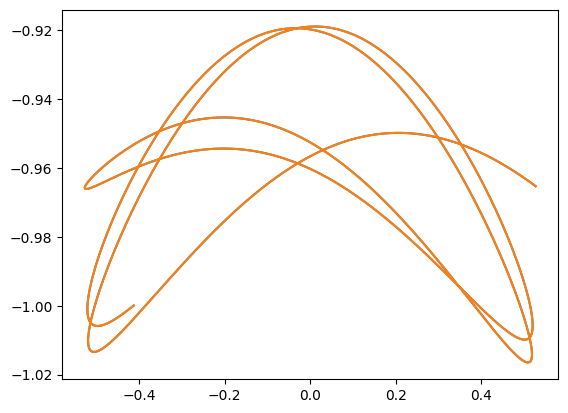

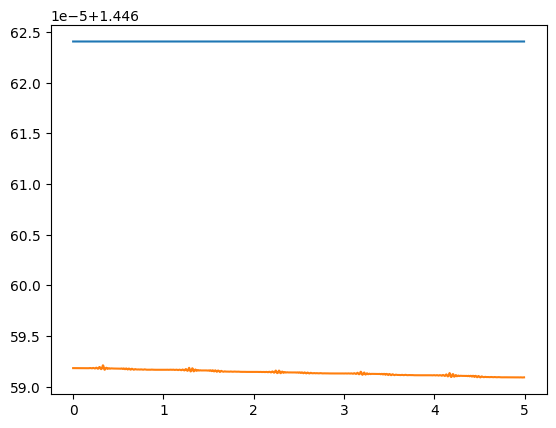

In [10]:

plt.plot(xy[:, 0], xy[:, 1])
plt.plot(txy[:, 0], txy[:, 1])
En = [E(x) for x in ppath]
Ent = [E(x) for x in tpath]
plt.show()
plt.plot(t, En)
plt.plot(t, Ent)
plt.show()

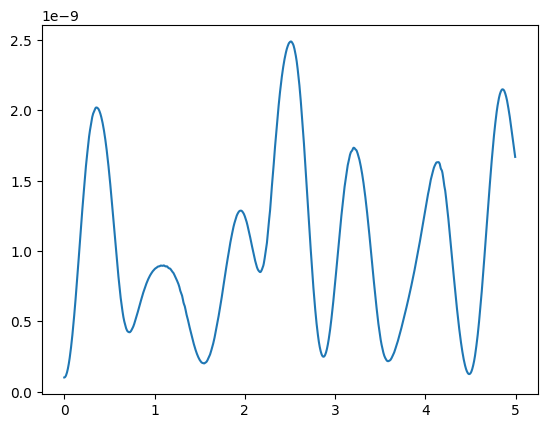

In [11]:
plt.plot(t, np.sum((tpath - ppath)**2, axis=1))

Now we have all we need to create and train the Lagrangian Neural Network

In [12]:
def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' #finding the default device

In [14]:
#creating the training dataset

t_train = torch.tensor(np.linspace(0, 10, 1500)).float()
t_test = torch.tensor(np.linspace(10, 20, 1500)).float()

tstep = t_train[1].item() 

x_train = torch.tensor(anal_solve_ode(q0, qt0, t_train)).float()
xt_train = torch.tensor(get_xt_anal(x_train, t_train)).float()
y_train = torch.tensor(rk4_step(get_xt_anal, x_train, t_train, tstep)).float()

x_test = torch.tensor(anal_solve_ode(q0, qt0, t_test)).float()
xt_test = torch.tensor(get_xt_anal(x_test, t_test)).float()
y_test = torch.tensor(rk4_step(get_xt_anal, x_test, t_test, tstep)).float()


In [15]:
#setting to default computing device
x_train = x_train.to(device)
xt_train = xt_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
xt_test = xt_test.to(device)
y_test = y_test.to(device)

In [16]:
#creatingthe LNN architecture

class LNN(nn.Module):
    def __init__(self):
        super(LNN, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def lagrangian(self, x): 
        x = F.softmax(self.fc1(x))
        x = F.softmax(self.fc2(x))
        x = self.fc3(x)
        return x 

    def forward(self, x):

        n = x.shape[1]//2
        xv = torch.autograd.Variable(x, requires_grad=True)
        xv_tup = tuple([xi for xi in x]) 

        tqt = xv[:, n:]


        jacpar = partial(jacobian,  self.lagrangian, create_graph=True)
        hesspar = partial(hessian,  self.lagrangian, create_graph=True)

        A = tuple(map(hesspar, xv_tup))
        B = tuple(map(jacpar, xv_tup))

        
        multi = lambda Ai, Bi, tqti, n:  torch.inverse(Ai[n:, n:]) @ (Bi[:n, 0] - Ai[n:, :n] @ tqti) 
        multi_par = partial(multi, n=n)

        tqtt_tup = tuple(map(multi_par, A, B, tqt))
        tqtt = torch.cat([tqtti[None] for tqtti in tqtt_tup])

        xt = torch.cat([tqt, tqtt], axis=1)
        xt.retain_grad()
        return xt

    def t_forward(self, t, x):
        return self.forward(x)


#setting the lagrangian loss function (in the original paper, it was set to be the L2 distance between the original and predicted outcomes)
    
def loss(pred, targ):
    return torch.mean((pred - targ)**2)

def nn_solve_ode(model, x0, t):

    x0 = x0.detach().numpy()
    def f(x, t):
        x_tor = torch.tensor(np.expand_dims(x, 0), requires_grad=True).float()
        return np.squeeze(model(x_tor).detach().numpy(), axis=0)
    return odeint(f, x0, t)  

In [17]:
# The training loop for the model
eps = 100
N = 1500 
batch_size = 100 

model = LNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_list = []
for e in range(eps):
    running_loss = 0.
    for i in range(1, N // batch_size):
        optimizer.zero_grad()
        xi = xt_train[(i-1)*batch_size:i*batch_size]
        xt_pred = model(xi)

        loss_val = loss(xt_pred, xt_train[i])
        loss_val.backward()

        optimizer.step()



        running_loss += loss_val.item()


    print('[%d, %5d] loss: %.10f' %
          (e + 1, i + 1, running_loss/N))
    
    loss_list.append(running_loss/N)
    running_loss = 0.0
        
        

[1,    15] loss: 886.7243620605
[2,    15] loss: 151.4369328931
[3,    15] loss: 6431.0662952932
[4,    15] loss: 4314.0205748736
[5,    15] loss: 6.8381831392
[6,    15] loss: 8.0251025899
[7,    15] loss: 74.5071382637
[8,    15] loss: 372.7481487719
[9,    15] loss: 1295.8681070054
[10,    15] loss: 738.8505769895
[11,    15] loss: 2.0508688037
[12,    15] loss: 7051.7285016232
[13,    15] loss: 0.7738024152
[14,    15] loss: 0.5436533508
[15,    15] loss: 2.0267686208
[16,    15] loss: 0.2122487806
[17,    15] loss: 0.1758391673


KeyboardInterrupt: 

In [22]:

nn_test = nn_solve_ode(model.cpu(), x_train[0].cpu(), t_train.cpu())


In [20]:
for i in range(10):
    print((nn_test[i], x_train[i]))

(array([1.10000002, 0.5       , 0.        , 0.        ]), tensor([1.1000, 0.5000, 0.0000, 0.0000], device='cuda:0'))
(array([ 1.09999998e+00,  4.99999922e-01, -7.73758742e-06, -1.40893966e-05]), tensor([ 1.0999,  0.4999, -0.0215, -0.0291], device='cuda:0'))
(array([ 1.09999990e+00,  4.99999781e-01, -1.54615925e-05, -2.81750417e-05]), tensor([ 1.0997,  0.4996, -0.0430, -0.0582], device='cuda:0'))
(array([ 1.09999978e+00,  4.99999546e-01, -2.31659935e-05, -4.22561340e-05]), tensor([ 1.0994,  0.4991, -0.0644, -0.0873], device='cuda:0'))
(array([ 1.09999959e+00,  4.99999218e-01, -3.08503609e-05, -5.63318690e-05]), tensor([ 1.0989,  0.4984, -0.0856, -0.1164], device='cuda:0'))
(array([ 1.09999936e+00,  4.99998795e-01, -3.85140656e-05, -7.04010708e-05]), tensor([ 1.0982,  0.4976, -0.1068, -0.1456], device='cuda:0'))
(array([ 1.09999908e+00,  4.99998278e-01, -4.61576400e-05, -8.44646831e-05]), tensor([ 1.0974,  0.4965, -0.1277, -0.1748], device='cuda:0'))
(array([ 1.09999875e+00,  4.99997668e

In [21]:
xt_train

tensor([[ 0.0000,  0.0000, -3.2242, -4.3584],
        [-0.0215, -0.0291, -3.2213, -4.3591],
        [-0.0430, -0.0582, -3.2129, -4.3610],
        ...,
        [-0.4281, -1.6524,  3.5576, -3.0637],
        [-0.4040, -1.6722,  3.6836, -2.8887],
        [-0.3790, -1.6909,  3.8023, -2.7047]], device='cuda:0')

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!